In [1]:
# %%
import pandas as pd 
# Load preprocessed data
train_df = pd.read_csv("train_data_final_2.csv")
test_df = pd.read_csv("test_data_final_2.csv")

# %%
# Inspect the first few rows
print("Training Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())


Training Data:
                                    tokenized_review  label  \
0  ['bromwell', 'high', 'cartoon', 'comedy', 'ran...      1   
1  ['homelessness', 'houselessness', 'george', 'c...      1   
2  ['brilliant', 'overacting', 'lesley', 'ann', '...      1   
3  ['easily', 'underrated', 'film', 'inn', 'brook...      1   
4  ['typical', 'mel', 'brooks', 'film', 'slapstic...      1   

                                       padded_review  
0  [1, 7323, 2274, 2956, 12444, 15823, 12104, 136...  
1  [1, 1, 6465, 1, 14855, 8270, 17417, 11633, 724...  
2  [1864, 11048, 1, 580, 16961, 1411, 4634, 1, 87...  
3  [4836, 16350, 5810, 7999, 1904, 2164, 15282, 5...  
4  [16264, 9793, 1904, 5810, 14290, 10269, 151, 1...  

Test Data:
                                    tokenized_review  label  \
0  ['went', 'saw', 'movie', 'night', 'coaxed', 'f...      1   
1  ['actor', 'turned', 'director', 'bill', 'paxto...      1   
2  ['recreational', 'golfer', 'knowledge', 'sport...      1   
3  ['saw', '

## RNNS

In [20]:
import torch
import pandas as pd 
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import ast 

class SentimentDataset(Dataset):
    def __init__(self, dataframe, max_length=105, vocab_size=10000):
        self.reviews = dataframe['padded_review']
        self.labels = dataframe['label']
        self.max_length = max_length
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        # Retrieve the token indices for the review
        indices = self.reviews.iloc[idx]

        # Initialize a multi-hot vector of length vocab_size
        multi_hot_vector = torch.zeros(self.vocab_size)

        # Set the corresponding indices to 1 in the multi-hot vector
        for index in indices:
            if index < self.vocab_size:
                multi_hot_vector[index] = 1

        # Retrieve the label and convert to tensor
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)

        return multi_hot_vector, label

from torch.utils.data import DataLoader

# Parameters
vocab_size = 10000  # Adjusted to match min(vocab_size, 10000) in your original code
max_length = 105
batch_size = 16

train_df = pd.read_csv('train_data_final_2.csv')
train_df = train_df.sample(n=400, random_state=42)  # Sampling 1000 examples due to dataset size

test_df = pd.read_csv('test_data_final_2.csv')
test_df = test_df.sample(n=200, random_state=42)  # Sampling 1000 examples due to dataset size


# Splitting data into train, dev, and test sets
# train_data, test_data = train_test_split(test_df, test_size=0.2, random_state=42)
train_data, dev_data = train_test_split(train_df, test_size=0.2, random_state=42)

test_data = test_df

# Truncate the sequences to max_length within the DataFrame
max_length = 105  

# Apply truncation directly to the 'padded_review' column in each DataFrame
train_df['padded_review'] = train_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])
dev_df = train_df.sample(frac=0.1, random_state=42)  # Extracting dev data from train_df
train_df = train_df.drop(dev_df.index)  # Remaining for training
test_df['padded_review'] = test_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])

# Ensure labels are numeric (convert if necessary)
train_df['label'] = pd.to_numeric(train_df['label'])
dev_df['label'] = pd.to_numeric(dev_df['label'])
test_df['label'] = pd.to_numeric(test_df['label'])

# Create datasets
train_dataset = SentimentDataset(train_df)
dev_dataset = SentimentDataset(dev_df)
test_dataset = SentimentDataset(test_df)

# Create DataLoaders
batch_size = 16

# Create datasets
train_dataset = SentimentDataset(train_df, max_length=max_length, vocab_size=vocab_size)
dev_dataset = SentimentDataset(dev_df, max_length=max_length, vocab_size=vocab_size)
test_dataset = SentimentDataset(test_df, max_length=max_length, vocab_size=vocab_size)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print data loader counts
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in dev loader: {len(dev_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")


Number of batches in training loader: 23
Number of batches in dev loader: 3
Number of batches in test loader: 13


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(SentimentGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU layer
        self.gru = nn.GRU(
            vocab_size,  # Input size is now vocab_size (multi-hot vector length)
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, seq_length]

        # Initialize hidden state (h0) with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        out, hn = self.gru(x.unsqueeze(1), h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Take the output from the last time step
        out = out[:, -1, :]  # (batch_size, hidden_size)

        # Pass through the fully connected layer
        out = self.fc(out)  # (batch_size, output_size)

        return out

# Parameters
vocab_size = 10000      # Adjusted to match min(vocab_size, 10000)
hidden_size = 256
output_size = 2          # Binary classification (positive and negative)
num_layers = 1           # Number of GRU layers
dropout = 0.5            # Dropout probability
learning_rate = 0.001
num_epochs = 10          # Allowing early stopping
weight_decay = 1e-5      # L2 regularization to avoid overfitting

# Initialize the model
model = SentimentGRU(vocab_size, hidden_size, output_size, num_layers, dropout)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print(model)


SentimentGRU(
  (gru): GRU(10000, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [25]:
import copy 
min_delta = 0.001  # Minimum change in the monitored quantity to qualify as an improvement
patience = 5  # Number of epochs with no improvement after which training will be stopped

# Lists to store loss and accuracy for plotting
train_losses = []
dev_losses = []
train_accuracies = []
dev_accuracies = []

best_dev_accuracy = 0.0
best_model_state = copy.deepcopy(model.state_dict())
counter = 0  # Initialize patience counter

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)  # [batch_size, seq_length]
        batch_Y = batch_Y.to(device)  # [batch_size]

        # Forward pass
        outputs = model(batch_X)  # [batch_size, output_size]
        loss = criterion(outputs, batch_Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

        # Compute training accuracy
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == batch_Y).sum().item()
        total_train += batch_Y.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Evaluation on development set
    model.eval()
    dev_running_loss = 0.0
    correct_dev = 0
    total_dev = 0
    with torch.no_grad():
        for batch_X, batch_Y in dev_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)
            outputs = model(batch_X)  # [batch_size, output_size]
            loss = criterion(outputs, batch_Y)
            dev_running_loss += loss.item() * batch_X.size(0)

            _, preds = torch.max(outputs, 1)  # [batch_size]
            correct_dev += (preds == batch_Y).sum().item()
            total_dev += batch_Y.size(0)

    epoch_dev_loss = dev_running_loss / len(dev_loader.dataset)
    epoch_dev_acc = correct_dev / total_dev
    dev_losses.append(epoch_dev_loss)
    dev_accuracies.append(epoch_dev_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Dev Loss: {epoch_dev_loss:.4f}, Dev Acc: {epoch_dev_acc:.4f}")

    # Check for improvement
    if epoch_dev_acc > best_dev_accuracy + min_delta:
        best_dev_accuracy = epoch_dev_acc
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0  # Reset counter if improvement occurs
#         print(f"--> Dev Accuracy improved to {best_dev_accuracy:.4f}.")
    else:
        counter += 1
#         print(f"--> No improvement in Dev Accuracy for {counter} epoch(s).")
        if counter >= patience:
            print("Early stopping triggered.")
            break  # Exit the training loop

# Load the best model
model.load_state_dict(best_model_state)
print(f"\nBest Dev Accuracy: {best_dev_accuracy:.4f}")

Epoch [1/10], Train Loss: 0.6722, Train Acc: 0.5917, Dev Loss: 0.6541, Dev Acc: 0.6000
Epoch [2/10], Train Loss: 0.3893, Train Acc: 0.9556, Dev Loss: 0.5895, Dev Acc: 0.6750
Epoch [3/10], Train Loss: 0.1371, Train Acc: 1.0000, Dev Loss: 0.6097, Dev Acc: 0.6250
Epoch [4/10], Train Loss: 0.0445, Train Acc: 1.0000, Dev Loss: 0.6447, Dev Acc: 0.6750
Epoch [5/10], Train Loss: 0.0183, Train Acc: 1.0000, Dev Loss: 0.6847, Dev Acc: 0.6750
Epoch [6/10], Train Loss: 0.0104, Train Acc: 1.0000, Dev Loss: 0.7219, Dev Acc: 0.6750
Epoch [7/10], Train Loss: 0.0066, Train Acc: 1.0000, Dev Loss: 0.7420, Dev Acc: 0.6750
Early stopping triggered.

Best Dev Accuracy: 0.6750


In [ ]:
# Evaluation on Test Set
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model.eval()
test_preds = []
test_labels = []
test_running_loss = 0.0
with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)
        outputs = model(batch_X)  # [batch_size, output_size]
        loss = criterion(outputs, batch_Y)
        test_running_loss += loss.item() * batch_X.size(0)

        _, preds = torch.max(outputs, 1)  # [batch_size]
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(batch_Y.cpu().numpy())

test_loss = test_running_loss / len(test_loader.dataset)
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Detailed metrics for each class
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    test_labels, test_preds, labels=[0, 1]
)

print("\nPer Class Metrics:")
print(f"Class 0 - Precision: {precision_per_class[0]:.4f}, Recall: {recall_per_class[0]:.4f}, F1-Score: {f1_per_class[0]:.4f}")
print(f"Class 1 - Precision: {precision_per_class[1]:.4f}, Recall: {recall_per_class[1]:.4f}, F1-Score: {f1_per_class[1]:.4f}")




Test Loss: 0.5907
Test Accuracy: 0.6700
Test Precision: 0.6696
Test Recall: 0.7333
Test F1-Score: 0.7000

Per Class Metrics:
Class 0 - Precision: 0.6706, Recall: 0.6000, F1-Score: 0.6333
Class 1 - Precision: 0.6696, Recall: 0.7333, F1-Score: 0.7000


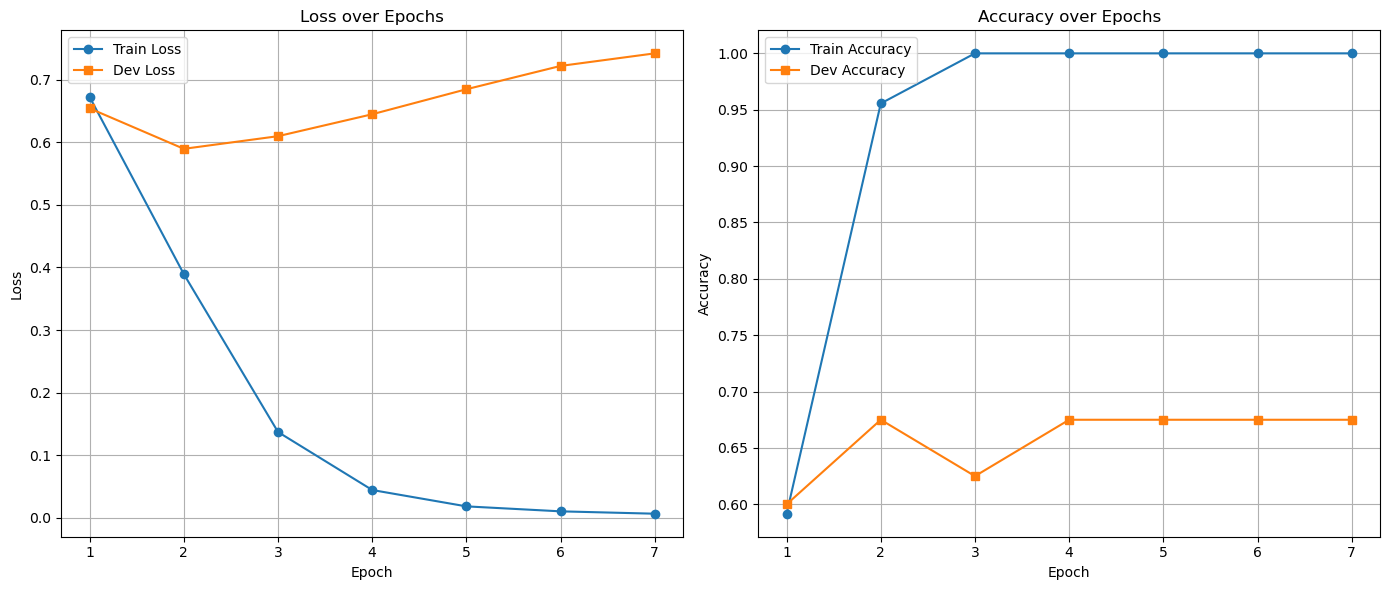

In [27]:
import matplotlib.pyplot as plt

# Plot Training Loss, Dev Loss, Training Accuracy, and Dev Accuracy
plt.figure(figsize=(14, 6))

# Plot Training and Development Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, len(dev_losses) + 1), dev_losses, marker='s', label='Dev Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Training and Development Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, len(dev_accuracies) + 1), dev_accuracies, marker='s', label='Dev Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
vocab = {
    "this": 1,
    "was": 2,
    "a": 3,
    "good": 4,
    "movie": 5,
    "after": 6,
    "all": 7
}


def predict_sentiment(sentence, model, vocab, max_length=105, vocab_size=17502):
    tokens = [vocab.get(word, 0) for word in sentence.split()]
    tokens = tokens[:max_length] + [0] * (max_length - len(tokens))
    multi_hot_vector = torch.zeros(vocab_size)
    for index in tokens:
        if index < vocab_size:
            multi_hot_vector[index] = 1
    multi_hot_vector = multi_hot_vector.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(multi_hot_vector)
    _, predicted = torch.max(output, 1)
    sentiment = "Positive" if predicted.item() == 1 else "Negative"
    print(f"Predicted label for the input sentence: {sentiment}")

# Example usage:
sentence = "this was a good movie after all"
print("Statement : ",sentence)
predict_sentiment(sentence, model, vocab, max_length=max_length, vocab_size=vocab_size)


Statement :  this was a good movie after all
Predicted label for the input sentence: Positive


#### Ends. 